In [1]:
using DataFrames, ForwardDiff, Plots

In [2]:
# Stochastic gradient descent, logit.

df = readtable("../data/parsed_model_australia.txt", separator = ' ', header = false)

a, b = size(df)

const n_individuals = a
const n_alternatives = 4
const n_parameters = b

head(df)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
1,4,1,0,0,0,0,1,0,0,0,0,1,0,35,0,0,0,69,34,35,0,70,71,70,30
2,4,1,0,0,0,0,1,0,0,0,0,1,0,30,0,0,0,64,44,53,0,68,84,85,50
3,4,1,0,0,0,0,1,0,0,0,0,1,0,40,0,0,0,69,34,35,0,129,195,149,101
4,4,1,0,0,0,0,1,0,0,0,0,1,0,70,0,0,0,64,44,53,0,59,79,81,32
5,4,1,0,0,0,0,1,0,0,0,0,1,0,45,0,0,0,64,44,53,0,82,93,94,99
6,2,1,0,0,0,0,1,0,0,0,0,1,0,20,0,0,0,69,40,35,0,70,57,58,43


In [3]:
function individual(β::Vector, i::Int64)
    m, n = size(df)
    choice = df[i, 1][1]
    data = convert(Array, df[i, 2:n_parameters])
    alternatives = collect(1:n_alternatives)
    splice!(alternatives, choice)
    
    function utility(β::Vector, k::Int64)
        temp = Float64[]
        k += 1
        while k <= n_parameters
            push!(temp, df[i, k])
            k += n_alternatives
        end
        return dot(temp, β)
    end
    
    function logit(β::Vector)
        t = 0.0
        c = utility(β, choice)
        for alternative in alternatives
            t += exp(utility(β, alternative)-c)
        end
        return 1/(1+t)
    end
    
    return logit
end

individual (generic function with 1 method)

In [4]:
function f(β::Vector)
    model = 0.0
    i = 1
    while i <= n_individuals
        logit = individual(β, i)
        model += log(logit(β))
        i += 1
    end
    return -model/n_individuals
end

f (generic function with 1 method)

In [5]:
function g(x::Vector, i::Int64, j::Int64)
    t = zeros(length(x))
    for k = i:j
        logit = individual(x, k)
        t += (1/logit(x))*ForwardDiff.gradient(logit, x)
    end
    return -t/j
end

function g!(x::Vector, i::Int64, j::Int64, storage::Vector)
    s = g(x, i, j)
    storage[1:length(s)] = s[1:length(s)]
end

g! (generic function with 1 method)

In [6]:
function scores!(x::Vector, i::Int64, j::Int64, t::Matrix)
    for k = i:j
        logit = individual(x, k)
        t[:, k] = (1/logit(x))*ForwardDiff.gradient(logit, x)
    end
    return -t
end

scores! (generic function with 1 method)

In [7]:
function stopCG(normg::Float64, normg0::Float64, k::Int, kmax::Int)
    χ::Float64 = 0.1
    θ::Float64 = 0.5
    if (k == kmax) || (normg <= normg0*min(χ, normg0^θ))
        return true
    else
        return false
    end
end

stopCG (generic function with 1 method)

In [8]:
function TruncatedCG(g::Vector, H::Matrix, Δ::Float64)
    n = length(g)
    s = zeros(n)
    normg0 = norm(g)
    v = g
    d = -v
    gv = dot(g, v)
    norm2d = gv
    norm2s = 0
    sMd = 0
    k = 0
    Δ2 = Δ*Δ
    while stopCG(norm(g), normg0, k, n) == false
        weight = 1.0/n_individuals
        κ = 0.0
        for j = 1:size(H)[2]
            κ += (dot(d, H[:, j]))^2
        end
        κ *= weight
        if κ <= 0
            σ = (-sMd+sqrt(sMd*sMd+norm2d*(Δ2-dot(s, s))))/norm2d
            s += σ*d
            break
        end
        α = gv/κ
        norm2s += α*(2*sMd+α*norm2d)
        if norm2s >= Δ2
            σ = (-sMd+sqrt(sMd*sMd+norm2d*(Δ2-dot(s, s))))/norm2d
            s += σ*d
            break
        end
        s += α*d
        for j = 1:size(H)[2]
            g += weight*(α*dot(H[:, j], d)*H[:, j])
        end
        v = g
        newgv = dot(g, v)
        β = newgv/gv
        gv = newgv
        d = -v+β*d
        sMd = β*(sMd+α*norm2d)
        norm2d = gv+β*β*norm2d
        k += 1
    end
    return s
end

TruncatedCG (generic function with 1 method)

In [9]:
function shuffle!(df::DataFrame)
    for i = size(df, 1):-1:2
        j = rand(1:i)
        df[i, :], df[j, :] = df[j, :], df[i, :]
    end
end

shuffle! (generic function with 1 method)

In [10]:
function graph()
    default(size = (700, 700), fc = :heat)
    β1, β2 = 0:0.05:1.0, 0:0.05:1.0
    z = Surface((β1, β2) -> f([β1, β2, 0, 0, 0, 0]), β1, β2)
    surface(β1, β2, z, linealpha = 0.3)
end

graph (generic function with 1 method)

In [11]:
function sgd(f::Function, g::Function, Step::Function, ω0::Vector, η::Float64,
    batch::Int64 = n_individuals, tol::Float64 = 1e-8, record::Bool = true)
    k = 0
    ω = ω0
    n = length(ω)
    dfx = ones(n)
    scores = zeros(n, batch)
    nmax = 500
    change = 1.0
    if record
        fω = f(ω)
        iterates = [fω ω']
    end
    while change > tol && k < nmax
        shuffle!(df)
        x = ω
        for i = 1:batch:n_individuals
            g(x, i, batch, dfx)
            scores!(x, i, batch, scores)
            step = Step(dfx, scores, η)
            ω += step
        end
        if record
            fω = f(ω)
            iterates = [iterates; fω ω']
        end
        change = abs(f(ω)-f(x))
        k += 1
    end
    if record
        return ω, k, iterates
    else
        return ω, k
    end
end

sgd (generic function with 4 methods)

In [12]:
sol, epochs, iter = sgd(f, g!, TruncatedCG, [5.0, 4.0, 3.0, 0.0, 0.0, 0.0], 0.01)

sol, epochs

([5.20702, 3.86923, 3.16245, 0.0132883, -0.096117, -0.0155061], 73)


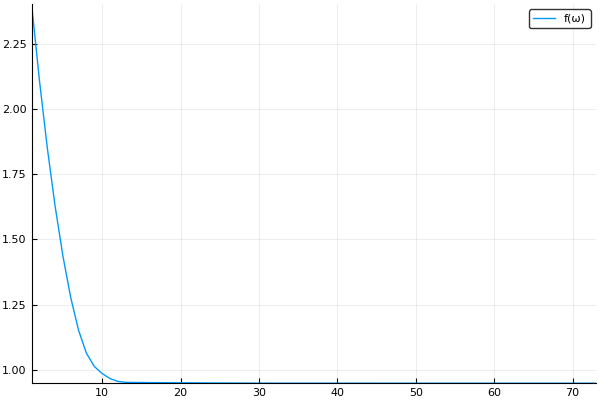

In [13]:
k = [x = i for i = 1:length(iter[:, 1])]

Plots.plot(k, iter[:, 1], label = "f(ω)")


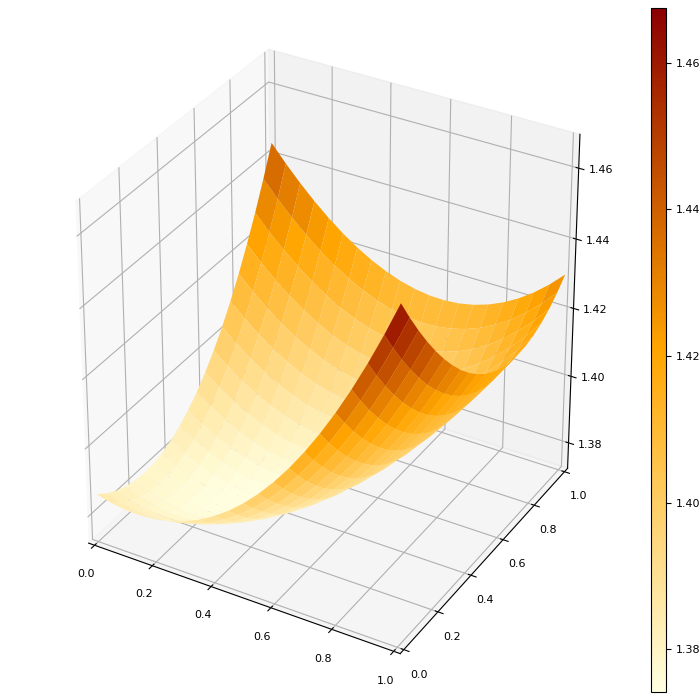

In [14]:
graph()